In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from log_analysis import *
import cw_utils, os

### Download the desired log file given the simulation ID 

In [2]:
############################################
AWS_PROFILE = 'heroacademy' # Change back to 'default'
model_name = 'MikeDevModel28' # Your trained model name
training_stream_name = 'sim-6m2clz471djk' # Training Stream Name in RoboMaker
evaluation_stream_name = 'sim-vglxp7ygyxlm' # Evaluation Stream Name in RoboMaker
track_name = 'reinvent_base' # Training Track Name
############################################
gpath = f'graphs/{model_name}'
ipath = f'intermediate_checkpoint/{model_name}'
spath = f'simulation_episode/{model_name}'
if not model_name or not training_stream_name or not evaluation_stream_name:
    raise Exception('Model name or any stream name cannot be empty')
if not os.path.isdir(gpath) or not os.path.isdir(ipath) or not os.path.isdir(spath):
    try:
        os.mkdir(spath)
        os.mkdir(ipath)
        os.mkdir(gpath)
        os.mkdir(f'{gpath}/Path taken in each interations')
        os.mkdir(f'{gpath}/Probability distribution on decisions')
    except Exception as e:
        pass
    # os.mkdir(f'{gpath}/Reward distribution in each interations')

In [3]:
# Download the training and evaluation log files
training_fname = f'logs/deepracer-{training_stream_name}.log'
evaluationl_fname = f'logs/deepracer-eval-{evaluation_stream_name}.log'
if not os.path.isfile(training_fname):
    cw_utils.download_log(training_fname, stream_prefix=training_stream_name, aws_profile=AWS_PROFILE)
if not os.path.isfile(evaluationl_fname):
    cw_utils.download_log(evaluationl_fname, stream_prefix=evaluation_stream_name, aws_profile=AWS_PROFILE)

In [4]:
try:
    s3_bucket = !grep "S3 bucket" $training_fname
    s3_prefix = !grep "S3 prefix" $training_fname
    s3_bucket = s3_bucket[0].split(':')[1].strip()
    s3_prefix = s3_prefix[0].split(':')[1].strip() 
except Exception as e:
    print(e)
    pass

## Load waypoints for the track you want to run analysis on
Tracks Available
* AWS_track
* Straight_track
* Oval_track
* Bowtie_track 
* H_track
* reinvent_base
* London_track


In [5]:
def get_track_waypoints(track_name):
    return np.load(f'tracks/{track_name}.npy')

waypoints = get_track_waypoints(track_name)
waypoints.shape

(71, 6)

## Visualize the Track and Waypoints

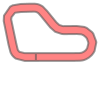

In [6]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

In [7]:
# rescale waypoints to centimeter scale
center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100

# Helper Functions 

In [8]:
def plot_track(df, track_size=(500, 800)):
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"])
        y = int(row["y"])
        reward = row["reward"]
        
        # clip values that are off track
        if y >= track_size[0]:
            y = track_size[0] - 1
        
        if x >= track_size[1]:
            x = track_size[1] - 1
        
        track[y,x] = reward 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [9]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 8 * n_laps))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'b.')
        
    return fig

## Load the training log

In [10]:
training_data = load_data(training_fname)
df = convert_to_pandas(training_data, None)
df.head()

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,2,387.85,8.65,-1.5083,0.00,5.0,3.0,0.00,1,False,5.4792,3,17.67,1559103214.968265
1,1,1,0,393.36,68.36,0.0003,0.00,0.0,0.0,1.40,0,True,0.7925,4,17.67,1559103215.8952959
2,1,1,1,395.35,68.30,-0.0029,0.17,5.0,4.0,1.40,0,True,0.9049,4,17.67,1559103216.0231686
3,1,1,2,402.45,68.35,0.0013,0.17,5.0,4.0,1.40,0,True,1.3065,4,17.67,1559103216.1519864
4,1,1,3,414.95,68.94,0.0296,0.17,5.0,4.0,1.54,0,True,2.0143,4,17.67,1559103216.278564


In [11]:
df['y'].min(), df['y'].max()

(8.649999999999999, 505.38)

In [12]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  387


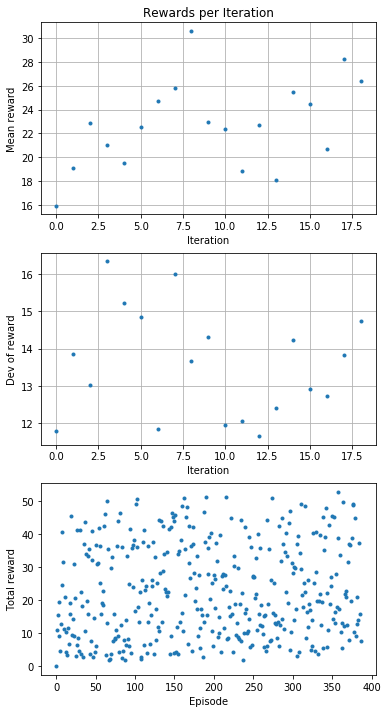

In [13]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')
plt.savefig(f'graphs/{model_name}/Rewards per Interation.png')

## Analyze the reward distribution for your reward function

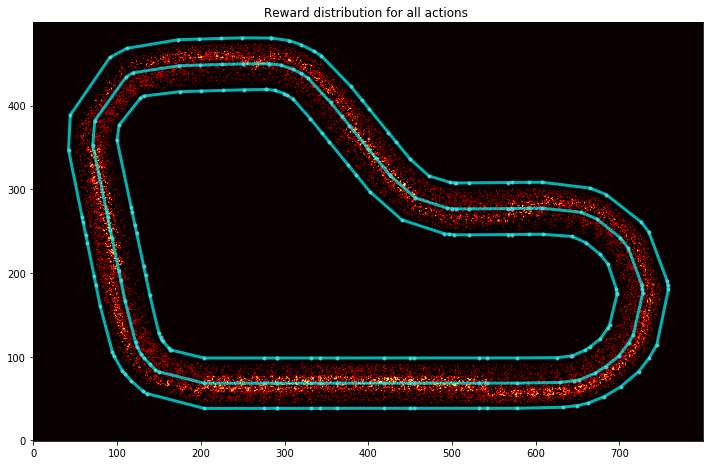

In [14]:
track = plot_track(df)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 
plt.savefig(f'{gpath}/Reward distribution for all actions.png')

### This will save all reward distribution in each reward graphs
# Don't run this if you don't need it, cause it save at least over TEN THOUSAND images to your directory.

In [15]:
# for i in range(0, len(df['iteration'])):
#     iteration_id = i
#     track = plot_track(df[df['iteration'] == iteration_id])
#     plt.title(f'Reward distribution for actions in Interation {i}')
#     plt.savefig(f'{gpath}/Reward distribution in each interations/iteration-id-{i}.png')

### Path taken for top reward iterations
NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

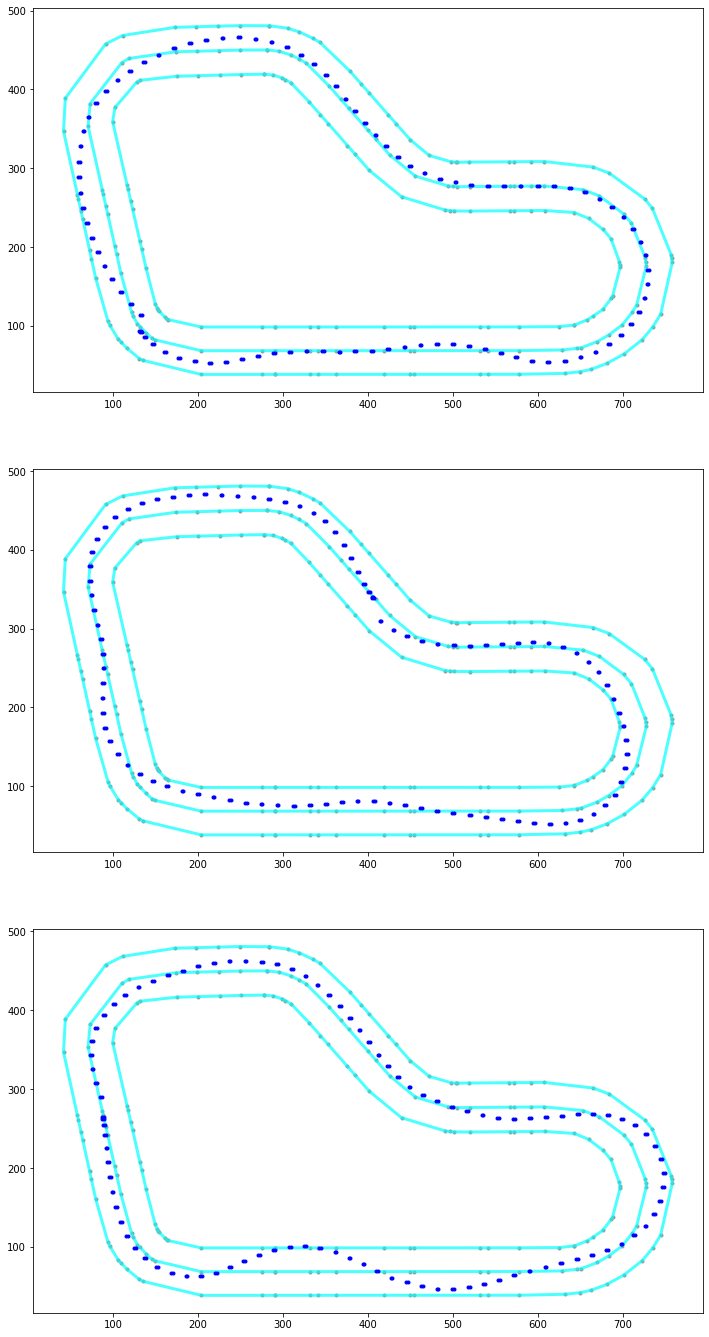

In [16]:
number_top_reward_interations = 3
action_map, episode_map, sorted_idx = episode_parser(training_data)    
fig = plot_top_laps(sorted_idx[:], number_top_reward_interations)
plt.savefig(f'{gpath}/{number_top_reward_interations} paths taken for top reward iterations.png')

### Path taken in a particular episode

In [17]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

In [18]:
# plot_episode_run(df, E=100) # arbitrary episode

### Path taken in all Iterations

In [19]:
for iteration_id in range(1, df['iteration'][len(df)-1]+1):
    for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
        plot_episode_run(df, E=i)
    plt.savefig(f'{gpath}/Path taken in each interations/interation-{iteration_id}')
    plt.clf()

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


<Figure size 864x1152 with 0 Axes>

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

** NOTE: This is only supported for reinvent track currently **

Number of steps in iteration= 337


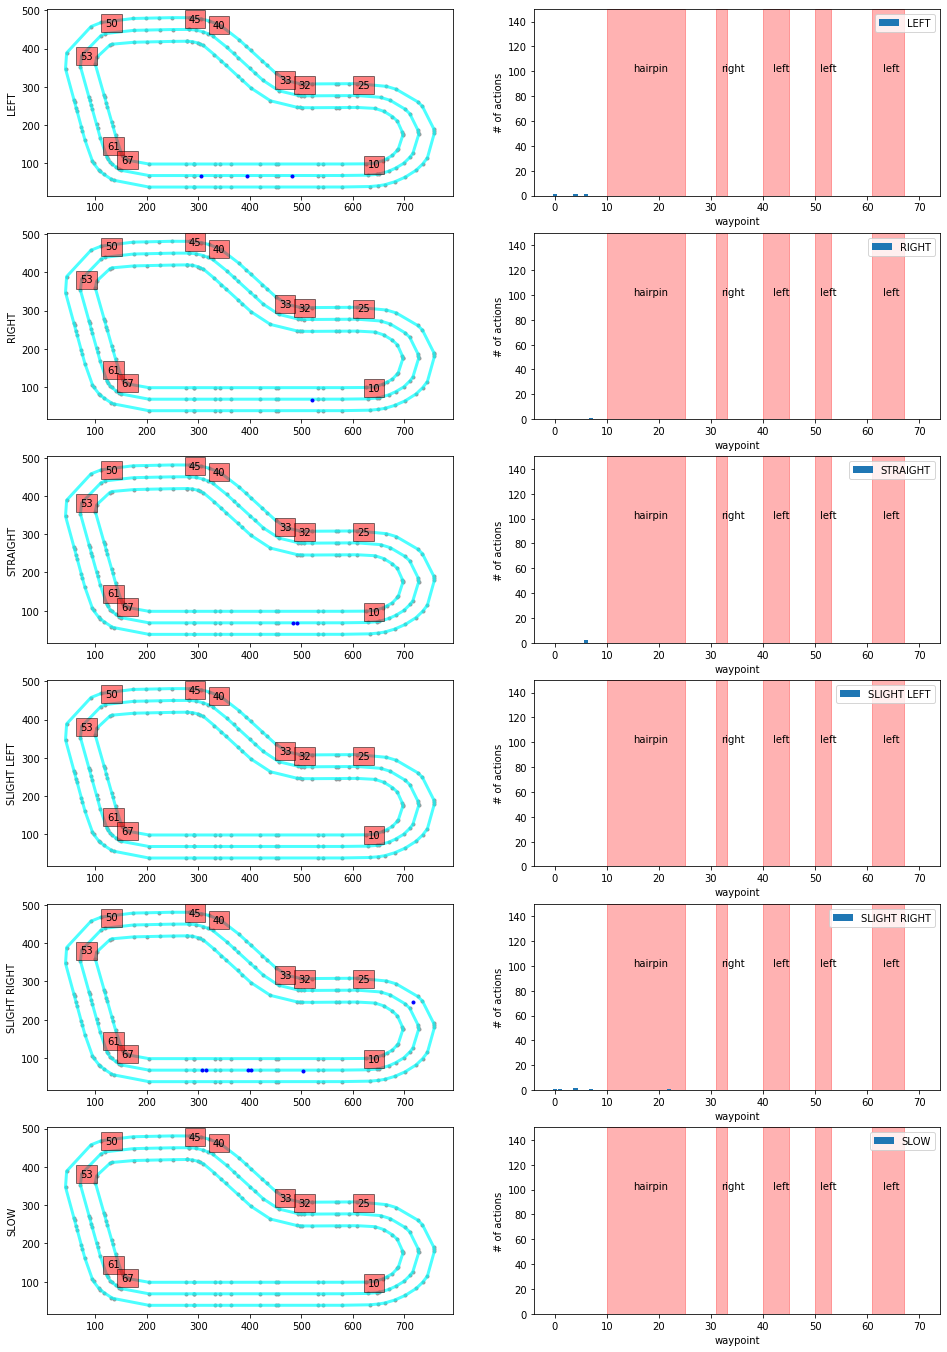

In [20]:
if track_name == 'reinvent_base':
    fig = plt.figure(figsize=(16, 24))
    iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

    # Track Segment Labels
    action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
    vert_lines = [10,25,32,33,40,45,50,53,61,67]
    track_segments = [(15, 100, 'hairpin'),
                      (32, 100, 'right'),
                      (42, 100, 'left'),
                      (51, 100, 'left'),
                      (63, 100, 'left')]

    segment_x = np.array([15, 32, 42, 51, 63])
    segment_y = np.array([0, 0, 0, 0, 0])

    segment_xerr = np.array([[5, 1, 2, 1, 2], [10, 1, 3, 2, 4]])
    segment_yerr = np.array([[0, 0, 0, 0, 0], [150, 150, 150, 150, 150]])

    wpts_array = center_line 

    for iter_num in iterations_downselect:

        # Slice the data frame to get all episodes in that iteration
        df_iter = df[(iter_num == df['iteration'])]
        n_steps_in_iter = len(df_iter)
        print('Number of steps in iteration=', n_steps_in_iter)

        th = 0.8
        for idx in range(len(action_names)):
            ax = fig.add_subplot(6, 2, 2*idx+1)
            print_border(ax, center_line, inner_border, outer_border) 

            df_slice = df_iter[df_iter['reward'] >= th]
            df_slice = df_slice[df_slice['action'] == idx]

            ax.plot(df_slice['x'], df_slice['y'], 'b.')

            for idWp in vert_lines:
                ax.text(wpts_array[idWp][0], wpts_array[idWp][1]+20, str(idWp), bbox=dict(facecolor='red', alpha=0.5))

            #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
            ax.set_ylabel(action_names[idx])

            # calculate action way point distribution
            action_waypoint_distribution = list()
            for idWp in range(len(wpts_array)):
                action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

            ax = fig.add_subplot(6, 2, 2 * idx + 2)

            # Call function to create error boxes
            _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

            for tt in range(len(track_segments)):
                ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

            ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
            ax.set_xlabel('waypoint')
            ax.set_ylabel('# of actions')
            ax.legend([action_names[idx]])
            ax.set_ylim((0, 150))
        plt.savefig(f'{gpath}/Action breakdown per iteration and historgram for action distribution for each of the turns.png')

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [21]:
evaluation_data = load_data(evaluationl_fname)
evaluation_df = convert_to_pandas(evaluation_data, None)
evaluation_df.head()

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,0,305.00,68.32,0.0002,0.00,0.0,0.0,1.0,0,True,0.7920,0,17.67,1559107691.7035904
1,1,0,1,306.80,68.24,-0.0053,0.17,5.0,4.0,1.0,0,True,0.8941,0,17.67,1559107691.894652
2,1,0,2,314.11,68.03,-0.0147,0.17,5.0,4.0,1.0,0,True,1.3077,1,17.67,1559107692.0235386
3,1,0,3,326.86,67.84,-0.0138,0.17,5.0,4.0,1.0,0,True,2.0294,1,17.67,1559107692.1500907
4,1,0,4,344.27,67.99,0.0043,0.17,5.0,4.0,1.0,0,True,3.0146,2,17.67,1559107692.2749095


## Grid World Analysis
    Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.

Episode 1
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 10.98 (meters), 7.68 (sec)
Average throttle, velocity = 4.92 (Gazebo), 1.43 (meters/sec)
###############################################################


Episode 2
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 14.64 (meters), 10.08 (sec)
Average throttle, velocity = 4.94 (Gazebo), 1.45 (meters/sec)
###############################################################


Episode 3
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 10.77 (meters), 7.46 (sec)
Average throttle, velocity = 4.92 (Gazebo), 1.44 (meters/sec)
###############################################################


Episode 4
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 11.72 (meters), 8.09 (sec)
Average throttle, velocity = 4.92 (Gazebo), 1.45 (m

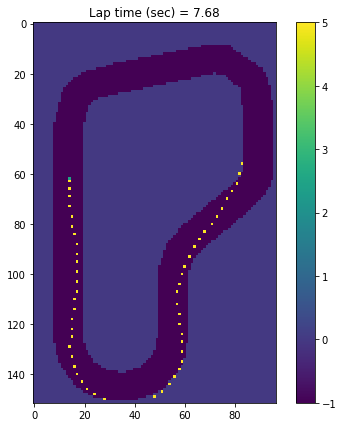

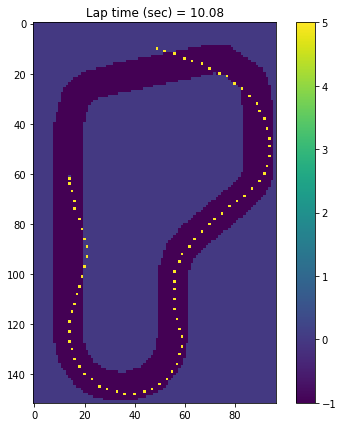

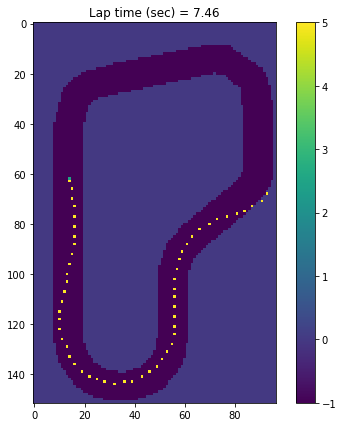

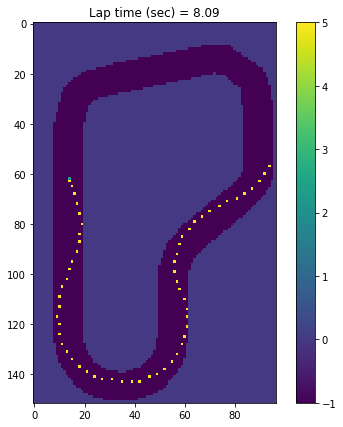

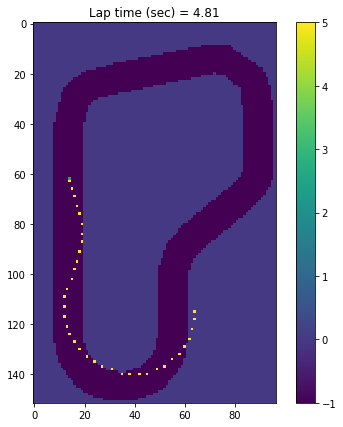

In [22]:
N_EPISODES = 5
for e in range(N_EPISODES):
    print (f'Episode {e + 1}')
    episode_df = evaluation_df[evaluation_df['episode'] == e]
    lap_time, average_throttle, stats = plot_grid_world(episode_df, inner_border, outer_border, scale=5.0)
    plt.savefig(f'{gpath}/Evaluation - Lap {e + 1} - {lap_time}secs.png')
    print ("###############################################################\n\n")

# Model CSV Analysis

Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model

In [23]:
fname = f'{ipath}/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv'
df_csv = pd.read_csv(fname)
title = "Training"
df_csv.plot(x='Training Iter', y='Training Reward', style='.', title=title)
plt.savefig(f'{gpath}/CSV Analysis Graph 1.png')

FileNotFoundError: [Errno 2] File b'intermediate_checkpoint/MikeDevModel28/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv' does not exist: b'intermediate_checkpoint/MikeDevModel28/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv'

In [ ]:
df_csv['Episode Length'].plot()
plt.savefig(f'{gpath}/CSV Analysis Graph 2.png')

## Download all the checkpoints

In [ ]:
!aws s3 sync s3://$s3_bucket/$s3_prefix/model/ $ipath/ --exclude "*" --include "*model_*" --profile=$AWS_PROFILE

## Simulation Image Analysis - Probability distribution on decisions (actions)
is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions

In [ ]:
import glob
original_img_path = "simulation_episode/original/"
all_files = sorted(glob.glob(original_img_path + '/*.png'))

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
model_inference = []
iterations = range(len(glob.glob1(ipath,"*.pb")))

for ii in iterations:
    model, obs, model_out = load_session(ipath + '/model_%s.pb' % ii)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

In [ ]:
for i in iterations:
    prob_diff = []
    for mi in model_inference[i]:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.savefig(f'{gpath}/Probability distribution on decisions/model_{i}.pb.png')
    plt.clf()